In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import zscore
from scipy.signal import correlate
import matplotlib.pyplot as plt
import seaborn as sns

def best_lag_corr(series1, series2):
    s1 = zscore(series1)
    s2 = zscore(series2)
    corr = correlate(s1, s2, mode='full')
    lags = np.arange(-len(s1)+1, len(s2))
    best_lag = lags[np.argmax(corr)]
    best_corr = np.max(corr) / len(series1)  # normalize by length
    return best_lag, best_corr

MERGED_DATA_DIR = "../../data/merged data"
OUTPUT_DIR = "../../output/assumption"

# Load the dataset
tnp_20 = pd.read_csv(os.path.join(MERGED_DATA_DIR, "2020", "merged_tnp_data.csv"))
tnp_19 = pd.read_csv(os.path.join(MERGED_DATA_DIR, "2019", "merged_tnp_data.csv"))

In [2]:
# 将 trip_start_date 列转换为 datetime 类型
tnp_20['trip_start_date'] = pd.to_datetime(tnp_20['trip_start_date'])
tnp_19['trip_start_date'] = pd.to_datetime(tnp_19['trip_start_date'])

# 计算 2020 年每日出行量
density_20 = (
    tnp_20.groupby('trip_start_date')
       .size()
       .reset_index(name='count_by_date')
)
density_20['year'] = '2020'

# 计算 2019 年每日出行量
density_19 = (
    tnp_19.groupby('trip_start_date')
          .size()
          .reset_index(name='count_by_date')
)
density_19['year'] = '2019'

lag, corr = best_lag_corr(density_20['count_by_date'], density_19['count_by_date'])
print(f"Best lag: {lag} days, Pearson-like correlation: {corr:.4f}")

Best lag: 0 days, Pearson-like correlation: 0.6943


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

Figure saved to: ../../output/assumption/trip_counts_comparison.pdf


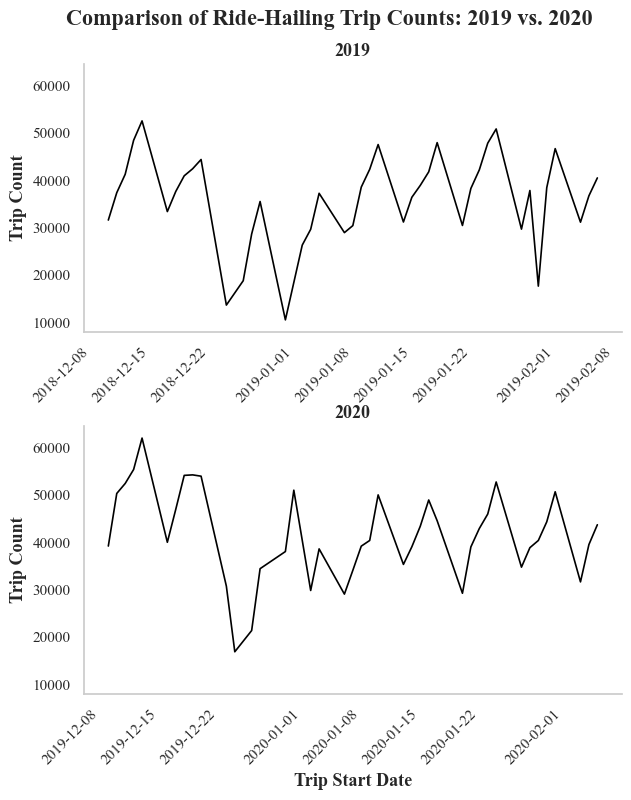

In [3]:
# 确保日期列格式正确
tnp_20['trip_start_date'] = pd.to_datetime(tnp_20['trip_start_date'])
tnp_19['trip_start_date'] = pd.to_datetime(tnp_19['trip_start_date'])

# 合并两个年份数据
density_combined = pd.concat([density_20, density_19], ignore_index=True)

# AEJ 样式设置
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.titleweight": "bold",
    "axes.labelweight": "bold"
})

g = sns.FacetGrid(
    density_combined,
    col="year",
    col_order=["2019", "2020"],
    col_wrap=1,
    height=4.5,
    aspect=1.5,
    sharex=False
)

g.map_dataframe(
    sns.lineplot,
    x='trip_start_date',
    y='count_by_date',
    color='black',
    linewidth=1.2
)

# 格式设置
g.set_titles("{col_name}")
g.set_axis_labels("Trip Start Date", "Trip Count")

# 去除背景网格 + 上右边框
for ax in g.axes.flat:
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

# 设置主标题（必须早于 subplots_adjust）
g.figure.suptitle("Comparison of Ride-Hailing Trip Counts: 2019 vs. 2020", fontsize=16, weight='bold')

# ✅ 手动精细控制间距，确保不重叠
g.figure.subplots_adjust(
    top=0.92,      # 主标题以上空间
    bottom=0.22,   # 横轴标签空间
    hspace=0.35    # Facet 子图间隔（⬅️ 关键）
)

# ✅ 保存图表（使用 bbox_inches 完整包含所有元素）
save_path = os.path.join(OUTPUT_DIR, "trip_counts_comparison.pdf")
g.figure.savefig(save_path, format="pdf", dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")

# ✅ 最后再显示
plt.show()